# Set up

In [5]:
import cv2
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rastertodataframe import raster_to_dataframe

import os

In [4]:
from osgeo import gdal
raster = gdal.Open("../data_tests/labrador/raws/2019-09-25-00_00_2019-09-25-23_59_Sentinel-2_L2A_B8A_(Raw).tiff")
test_raw = np.array(raster.ReadAsArray())
type(test_raw)

numpy.ndarray

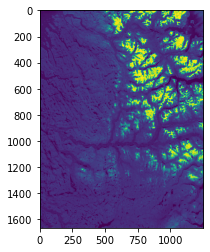

In [34]:
#open tif true color convert to array
img = gdal.Open("../data_tests/labrador/2019-09-25-00_00_2019-09-25-23_59_Sentinel-2_L2A_True_color.tiff")
test_color = np.array(img.ReadAsArray())

#convert RGB array to greyscale
def grayConversion(image):
    b = image[0, ...]
    g = image[1, ...]
    r = image[2, ...]
    gray_img = 0.21 * r + 0.72 * g + 0.07 * b
    return gray_img

test_gray = grayConversion(test_color)
plt.imshow(test_gray)

In [41]:
test_gray

array([[0.032645  , 0.0332725 , 0.0331975 , ..., 0.196265  , 0.19687   ,
        0.1855125 ],
       [0.0320875 , 0.03325   , 0.03322   , ..., 0.19184251, 0.20183751,
        0.19052501],
       [0.0318175 , 0.0338825 , 0.03358   , ..., 0.20894249, 0.23401752,
        0.22936   ],
       ...,
       [0.12067751, 0.08329   , 0.1204475 , ..., 0.06549   , 0.111075  ,
        0.0750375 ],
       [0.129525  , 0.10752001, 0.11732001, ..., 0.089665  , 0.0843325 ,
        0.0512425 ],
       [0.1066625 , 0.1115825 , 0.1153575 , ..., 0.088385  , 0.1145    ,
        0.094885  ]], dtype=float32)

# Filtering

## Gaussian

In [66]:
from osgeo.gdalconst import *
from osgeo import gdal
from scipy.ndimage import gaussian_filter, median_filter
from skimage.filters import difference_of_gaussians, gaussian
from scipy.signal import medfilt2d
def gaussian_raws(path_to_dir,  sigma = 1, nrcan_name = 'NRCAN_transformed.tif', index = [-14,-11]):
    raw_files = list(os.listdir(path_to_dir))

    gauss_df = pd.DataFrame()
    for i in raw_files:

        raw_img = gdal.Open(os.path.join(path_to_dir, i))
   
        rows = raw_img.RasterYSize
        cols = raw_img.RasterXSize
        
        raw_array = np.array(raw_img.ReadAsArray())
        
        raw_gauss = gaussian_filter(raw_array, sigma = sigma)
        
        raw_gauss = raw_gauss.flatten()
        gauss_df[i[index[0]:index[1]]] = raw_gauss
    
    nrcan_array = raster_to_dataframe(os.path.join(path_to_dir, '..', nrcan_name))
   
    print(nrcan_array.value_counts())
    gauss_df['y'] = nrcan_array.values
    return gauss_df
                
test_gauss = gaussian_raws('../data_tests/demo/raws', nrcan_name = 'land_cover.tif', index = [0, 3])


Band_1
14        1786474
1         1295963
5          754883
15         389203
8          327876
6          319587
18         304956
10          32747
17          24855
16           8532
255          4599
2             229
12             96
dtype: int64


In [10]:
#raster = gdal.Open("../data_tests/labrador/raws/2019-09-25-00_00_2019-09-25-23_59_Sentinel-2_L2A_B12_(Raw).tiff")
raster = gdal.Open("../data_tests/demo/raws/B12.tif")
test_raw = np.array(raster.ReadAsArray())

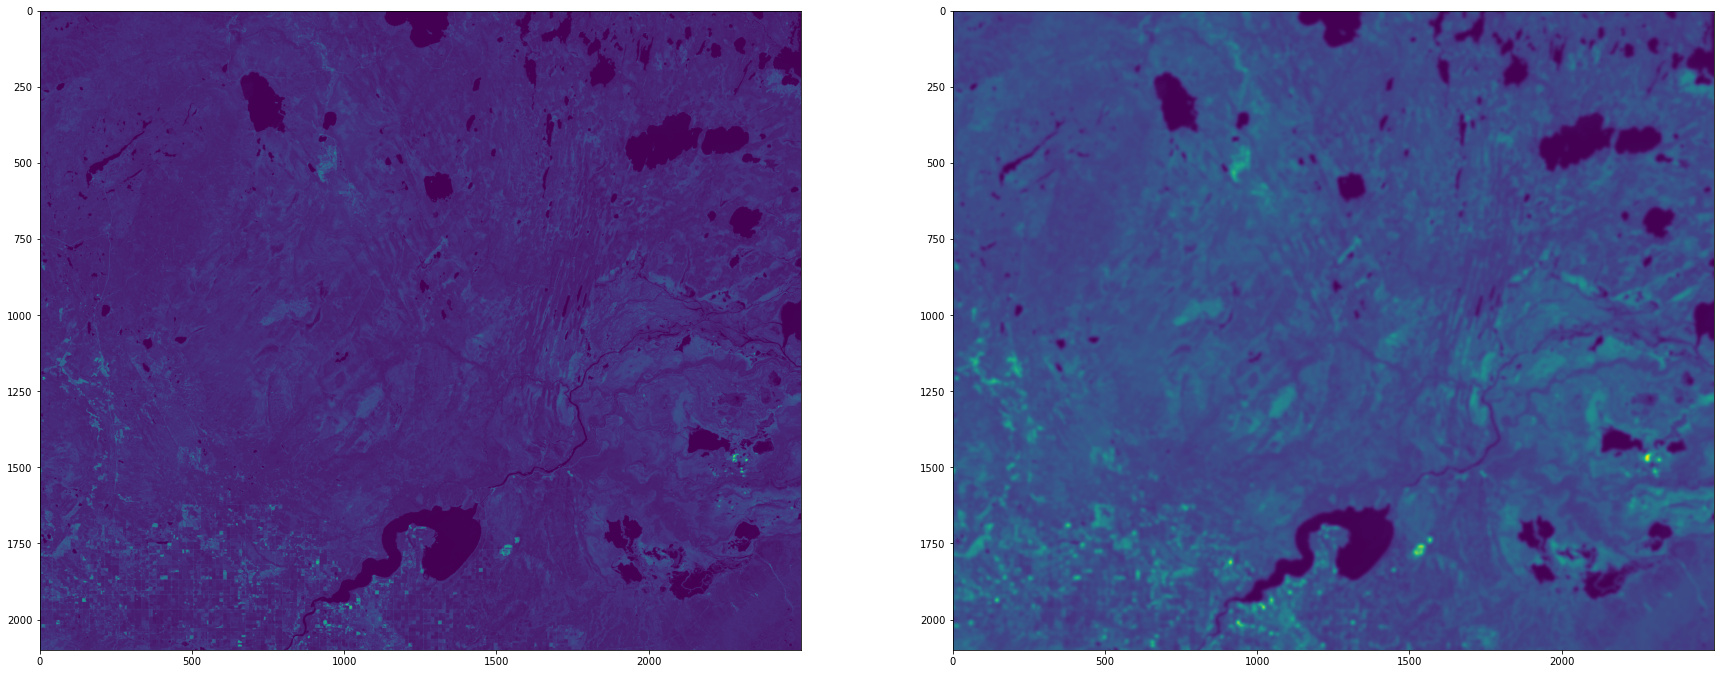

In [22]:
fig = plt.figure(figsize=(30, 15))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

raw_gauss = gaussian(test_raw, sigma=5)

ax1.imshow(test_raw)
ax2.imshow(raw_gauss)

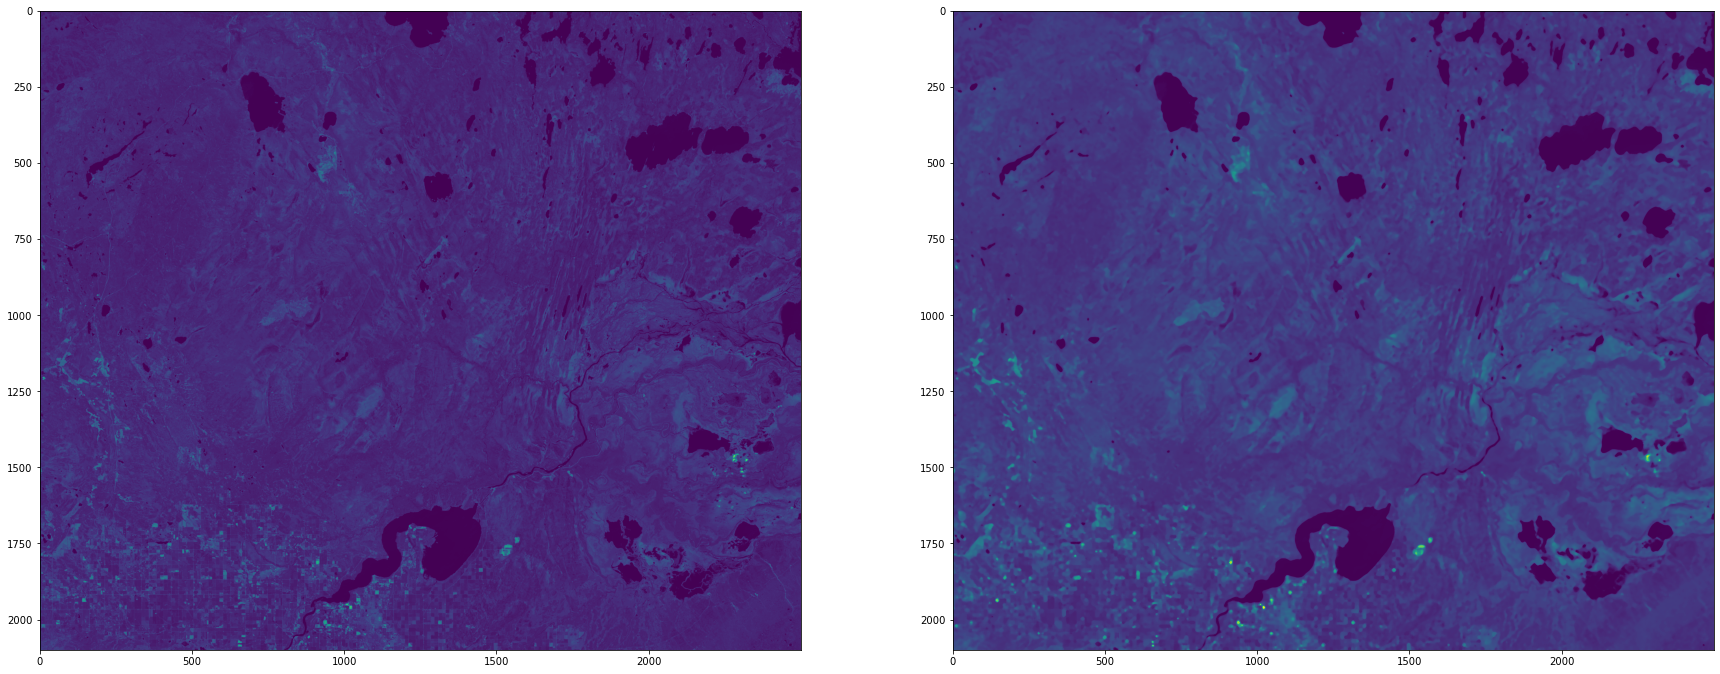

In [72]:
fig = plt.figure(figsize=(30, 15))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

med_gauss = median_filter(test_raw, size = 10)

ax1.imshow(test_raw)
ax2.imshow(med_gauss)

## Butterworth

In [35]:
from platform import python_version

print(python_version())

3.9.7


In [42]:
import skimage

print(skimage.__version__)

0.18.3


In [38]:
!pip install scikit-image

In [45]:
from skimage.filters import gabor

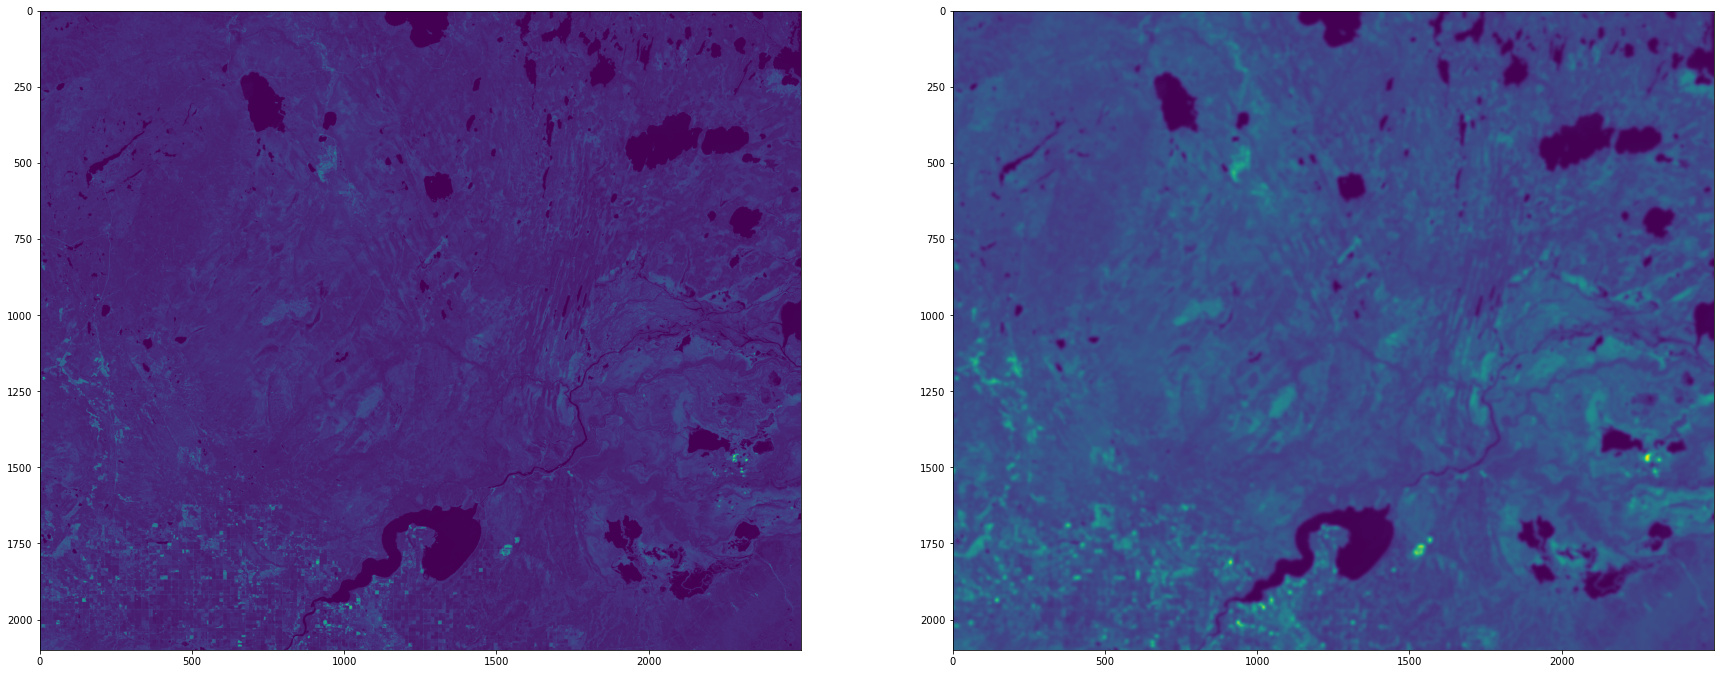

In [62]:
fig = plt.figure(figsize=(30, 15))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

raw_gauss = gaussian(test_raw, sigma = 5, preserve_range = True)

ax1.imshow(test_raw)
ax2.imshow(raw_gauss)

# Segmentation

## Region based

Source code from [here](https://www.analyticsvidhya.com/blog/2021/09/image-segmentation-algorithms-with-implementation-in-python/)

Text(0.5, 1.0, 'elevation_map')

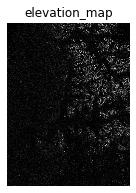

In [37]:
from skimage.filters import sobel
from skimage import morphology

elevation_map = sobel(test_gray)

fig, ax = plt.subplots(figsize=(4, 3))

ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')

ax.axis('off')

ax.set_title('elevation_map')

C:\Users\fynn\Documents\anaconda\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
C:\Users\fynn\AppData\Local\Temp/ipykernel_5564/3103435438.py:33: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  image_label_overlay = label2rgb(labeled_raw, image=test_gray)


NameError: name 'margins' is not defined

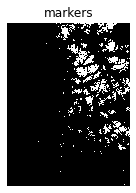

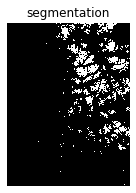

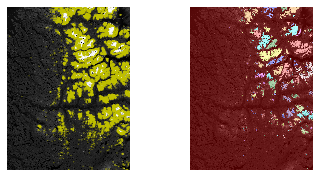

In [43]:
markers = np.zeros_like(test_gray)

markers[test_gray < 0.5] = 1

markers[test_gray > 0.5] = 2

fig, ax = plt.subplots(figsize=(4, 3))

ax.imshow(markers, cmap=plt.cm.gray, interpolation='nearest')

ax.axis('off')

ax.set_title('markers')

segmentation = morphology.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(4, 3))

ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')

ax.axis('off')

ax.set_title('segmentation')

from skimage.color import label2rgb

from scipy import ndimage as ndi

segmentation = ndi.binary_fill_holes(segmentation - 1)

labeled_raw, _ = ndi.label(segmentation)

image_label_overlay = label2rgb(labeled_raw, image=test_gray)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)

ax1.imshow(test_gray, cmap=plt.cm.gray, interpolation='nearest')

ax1.contour(segmentation, [0.5], linewidths=1.2, colors='y')

ax1.axis('off')

ax1.set_adjustable('box')

ax2.imshow(image_label_overlay, interpolation='nearest')

ax2.axis('off')

ax2.set_adjustable('box')

fig.subplots_adjust(**margins)

## Edge

C:\Users\fynn\AppData\Local\Temp/ipykernel_5564/569010145.py:13: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  raw_segments = slic(test_gray,


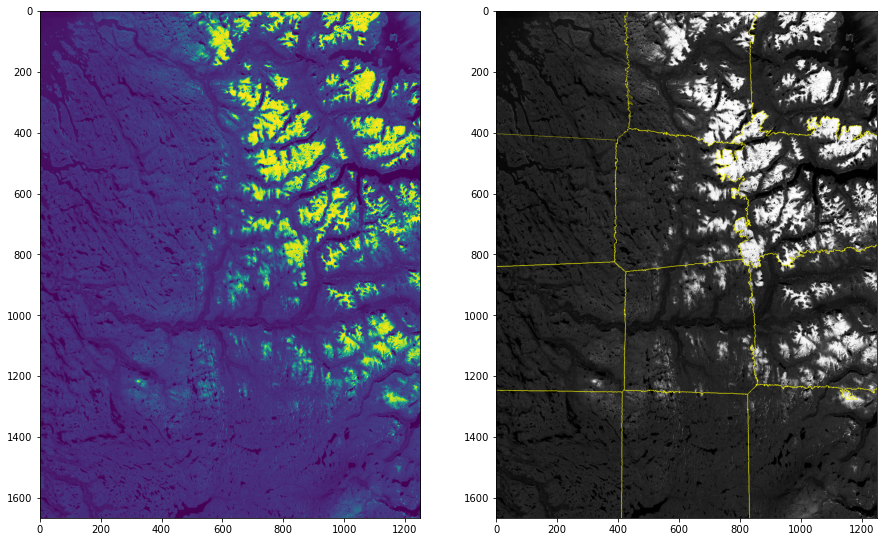

In [36]:
# Importing required boundaries
from skimage.segmentation import slic, mark_boundaries

# Setting the plot figure as 15, 15
plt.figure(figsize=(15, 15))
 
# Applying SLIC segmentation
# for the edges to be drawn over
raw_segments = slic(test_gray,
                          n_segments=12,
                          compactness=1)
 
plt.subplot(1, 2, 1)
 
# Plotting the original image
plt.imshow(test_gray)
 
# Detecting boundaries for labels
plt.subplot(1, 2, 2)
 
# Plotting the ouput of marked_boundaries
# function i.e. the image with segmented boundaries
plt.imshow(mark_boundaries(test_gray, raw_segments))

## Clustering

In [59]:
plt.imshow(image)
plt.plot(640, 570, "og", markersize=10)  # og:shorthand for green circle
plt.scatter(pts[:, 0], pts[:, 1], marker="x", color="red", s=200)
plt.show()

[604.5479452054794, 615.6849315068494]

In [47]:
import math
import random

n=int(20)
l1=[]
l2=[]
for i in range (1,n+1):
    l1.append(int(random.randint(1, test_gray.shape[0])))
    l2.append(int(random.randint(1, test_gray.shape[1])))
l=zip(l1,l2)                            #combines the 2lists to create a list of tuples #((1,1),(2,1))
p=list(l)                               #converts l to list           [(1,1),(2,1)]
print("The points are = ",p)
a=int(input("Enter the number of clusters = "))
k=[]
b=[]
for i in range (0,a):                   #a -> no. of clusters
    m=list(p[i])                        #converts each tuple(consisting of co-ordinates) to list [[1,1],[2,1]]
    k.append(m)                         #list carrying the centroids
    b.append(m)                         #copy of centroids used later to chk if the repeat 
print("The centroids are = ",k)
print()
y=[]                                    #distance matrix
while True:
    for j in range (0,a):    
        x=[]                            #sublist in y considering dist of each pt from each cluster
        for i in range (0,n):
            q=math.pow(p[i][0]-k[j][0],2)
            w=math.pow(p[i][1]-k[j][1],2)
            t=math.sqrt(q+w)
            x.append(t)
            h=list(x)
        y.append(h)
    print("The distance of all points from centroid is : ")
    print()
    for i in range (0,a):
        for j in range (0,n):
            v=y[i][j]
            print("{:.2f}".format(v))      # a=13.946 print("{0:.2f}".format(a)) #13.95
        print()
    print()
    g=[]                                #new cluster
    for i in range (0,a):
        g.append([])                    #creating sublists in g which is equal to no. of clusters
    for i in range (0,n):
        min1=y[0][i]                    #dist of pt from 1st cluster
        for j in range (1,a):
            if(min1>y[j][i]):
                g[j].append(i)
            else:
                g[0].append(i)
    print("New clusters are :",g)
    print()
    k.clear()                           #cal new centroids
    for i in range(0,a):
        j=0
        s1=0.0
        s2=0.0
        while(j<len(g[i])):
            e=g[i][j]
            s1=s1+l1[e]
            s2=s2+l2[e]
            j=j+1
        c1=s1/len(g[i])
        c2=s2/len(g[i])
        k.append([c1,c2])
    print("The new centroids are = ",k)
    print()
    x.clear()
    y.clear()
    g.clear()
    if(b==k):
        break
    else:
        b.clear()
        b=k
print()
print("Final centroids are = ",k)

The points are =  [(256, 559), (1247, 446), (93, 420), (679, 173), (1561, 704), (571, 1246), (1303, 562), (958, 1055), (1458, 280), (927, 716), (1339, 1243), (216, 656), (745, 720), (852, 91), (203, 376), (652, 572), (943, 133), (517, 1248), (1580, 95), (1363, 10)]


Enter the number of clusters =  20


The centroids are =  [[256, 559], [1247, 446], [93, 420], [679, 173], [1561, 704], [571, 1246], [1303, 562], [958, 1055], [1458, 280], [927, 716], [1339, 1243], [216, 656], [745, 720], [852, 91], [203, 376], [652, 572], [943, 133], [517, 1248], [1580, 95], [1363, 10]]

The distance of all points from centroid is : 

0.00
997.42
214.22
572.65
1313.03
755.77
1047.00
859.55
1233.96
689.12
1280.92
104.92
514.82
757.79
190.52
396.21
808.36
736.78
1402.95
1235.66

997.42
0.00
1154.29
630.20
406.40
1047.37
128.81
674.09
268.47
418.69
802.29
1052.17
571.91
531.08
1046.34
608.19
436.33
1084.48
483.83
451.17

214.22
1154.29
0.00
635.93
1495.22
954.34
1218.30
1073.06
1372.16
884.97
1493.27
266.13
717.71
827.24
118.47
579.30
897.14
930.25
1522.10
1334.54

572.65
630.20
635.93
0.00
1029.51
1078.42
735.32
925.08
786.31
596.95
1257.18
669.07
550.97
191.45
517.48
399.91
267.01
1087.14
904.37
703.15

1313.03
406.40
1495.22
1029.51
0.00
1128.66
294.50
697.72
436.33
634.11
582.93
1345.86
816.16
937.26
13